# PARAMETERS 

In [10]:
problem_name = 'roads' #to save
model_architecture = 'unet'
weights_path = None 
target_size = (256, 256) 
batch_size = 2

epochs = 100 #após x épocas sem melhorar pará (a usar callback)

In [71]:
import signal
import keras
#from keras_tqdm import TQDMNotebookCallback
from keras.layers import Input
from keras.optimizers import Adam, RMSprop
from keras.models import Model, Sequential
from keras.models import load_model
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Conv2D, Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation
from keras.constraints import maxnorm 
from keras.optimizers import SGD 
from keras.utils import np_utils 
from keras import backend as K 
from keras.utils.data_utils import get_file
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
import keras
K.set_image_dim_ordering('tf') #ordem 'th' ou 'tf' 
import numpy as np
from numpy import genfromtxt
import math 

from timeit import default_timer as timer
from time import time as tick
import matplotlib.pyplot as plt 
import pickle 
from os import listdir
from PIL import Image, ImageOps
from os.path import isfile, join
import os
from scipy.misc	import toimage 
from scipy import misc, ndimage
import scipy.fftpack as pack
import scipy.misc
from scipy.ndimage import rotate
from sklearn.datasets import fetch_mldata
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from skimage.io import imread
from skimage.transform import resize

from sklearn.metrics import roc_auc_score
import pandas as pd
import pathlib

from keras.layers import (Activation, Conv2D, Conv2DTranspose, Dense, Dropout,
                          Flatten, Input, MaxPooling2D, concatenate,
                          GlobalAveragePooling2D)

# fixar random seed para se puder reproduzir os resultados 
seed = 1 
np.random.seed(seed) 

# Útils

In [72]:
def print_model(model,fich):
    from keras.utils import plot_model
    plot_model(model, to_file=fich, show_shapes=True, show_layer_names=True)
    
def print_history_accuracy(history):
    print(history.history.keys())
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
def print_history_loss(history):
    print(history.history.keys())
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

def load_batch(fpath, label_key='labels'): 
 
    f = open(fpath, 'rb') 
    d = pickle.load(f, encoding='bytes') 
    d_decoded = {}        # decode utf8 
    for k, v in d.items(): 
        d_decoded[k.decode('utf8')] = v 
    d = d_decoded 
    f.close() 
    data = d['data'] 
    labels = d[label_key] 
    data = data.reshape(data.shape[0], 3, 32, 32) 
    return data, labels


def rotate_resize(temp, tam_image):
    #-------------------rodar se necessário e cortar em quadrado
    if temp.shape[0] > temp.shape[1]:
        temp = rotate(temp,90)
    
    #cortar em quadrado no centro da imagem e fazer resize para o tam_image
    difShapes = temp.shape[1]-temp.shape[0]
    return (255 * resize(temp[0:temp.shape[0],int(difShapes/2):int(difShapes/2)+temp.shape[0]],
                            (tam_image, tam_image))).astype(np.uint8)

# Models

In [73]:
#choosing model

def choosing_model(model_architecture, num_classes,epochs, weights_path=None):
    
    model = None
    
    if model_architecture == 'unet':
        model = unet(input_tensor, input_shape=None, nb_classes=None)
    if model == None:
        print('non valid model')
        
    return model

In [95]:
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)

    return (2. * intersection + smooth) / (
        K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def build_unet(input_tensor, input_shape=None, nb_classes=None):
    # Makes 4 downsamplings
    # 2^4=16 » Minimum image size allowed is 32x32
    conv1 = Conv2D(32, (3, 3), activation="relu", padding="same")(input_tensor)
    conv1 = Conv2D(32, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(64, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(128, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(256, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation="relu", padding="same")(pool4)
    conv5 = Conv2D(512, (3, 3), activation="relu", padding="same")(conv5)

    up6 = concatenate(
        [
            Conv2DTranspose(256, (2, 2), strides=(2, 2),
                            padding="same")(conv5), conv4
        ],
        axis=3)
    conv6 = Conv2D(256, (3, 3), activation="relu", padding="same")(up6)
    conv6 = Conv2D(256, (3, 3), activation="relu", padding="same")(conv6)

    up7 = concatenate(
        [
            Conv2DTranspose(128, (2, 2), strides=(2, 2),
                            padding="same")(conv6), conv3
        ],
        axis=3)
    conv7 = Conv2D(128, (3, 3), activation="relu", padding="same")(up7)
    conv7 = Conv2D(128, (3, 3), activation="relu", padding="same")(conv7)

    up8 = concatenate(
        [
            Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(conv7),
            conv2
        ],
        axis=3)
    conv8 = Conv2D(64, (3, 3), activation="relu", padding="same")(up8)
    conv8 = Conv2D(64, (3, 3), activation="relu", padding="same")(conv8)

    up9 = concatenate(
        [
            Conv2DTranspose(32, (2, 2), strides=(2, 2), padding="same")(conv8),
            conv1
        ],
        axis=3)
    conv9 = Conv2D(32, (3, 3), activation="relu", padding="same")(up9)
    conv9 = Conv2D(32, (3, 3), activation="relu", padding="same")(conv9)

    conv10 = Conv2D(3, (1, 1), activation="sigmoid")(conv9)

    model = Model(inputs=[input_tensor], outputs=[conv10])

    model.compile(
        optimizer=Adam(lr=1e-5),
        loss="mean_squared_error",
        metrics=[dice_coef])

    print(model.summary())

    return model

# Callbacks

In [75]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

history_loss = LossHistory() #print(history.losses) to use      

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, mode='min')    

checkpoint = ModelCheckpoint(filepath = 'D:\models\checkpoint-{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', save_best_only=True, mode='min', period=1)

#reduce training rate when no improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

csv_logger = CSVLogger('training.log')



# Catch SIGINT (same as 'Ctrl+C') signals handler
class SignalStopping(keras.callbacks.Callback):
    """
    Stop training when an interrupt signal (or other) was received
    """

    def __init__(self, sig=signal.SIGINT, doubleSignalExits=False, verbose=0):
        """
        Stop training when an interrupt signal (or other) was received
        
        Keyword Arguments:
            sig {signal} -- The signal to listen to. Defaults to signal.SIGINT. (default: {signal.SIGINT})
            doubleSignalExits {bool} -- Receiving the signal twice exits the python process instead of waiting for this epoch to finish. (default: {False})
            verbose {int} -- Verbosity mode. (default: {0})
        """

        super(SignalStopping, self).__init__()

        self.signal_received = False
        self.verbose = verbose
        self.doubleSignalExits = doubleSignalExits

        def signal_handler(sig, frame):
            if self.signal_received and self.doubleSignalExits:
                if self.verbose > 0:
                    print(
                        ""
                    )  #new line to not print on current status bar. Better solution?
                    print("Received signal to stop " + str(sig) +
                          " twice. Exiting..")
                exit(sig)

            self.signal_received = True
            if self.verbose > 0:
                print(
                    ""
                )  #new line to not print on current status bar. Better solution?
                print("Received signal to stop: " + str(sig))

        signal.signal(signal.SIGINT, signal_handler)
        self.stopped_epoch = 0

    def on_epoch_end(self, epoch, logs={}):
        if self.signal_received:
            self.stopped_epoch = epoch
            self.model.stop_training = True

    def on_train_end(self, logs={}):
        if self.stopped_epoch > 0 and self.verbose > 0:
            print("Epoch %05d: stopping due to signal" % (self.stopped_epoch))

            
stop = SignalStopping()   

# Training

In [76]:
# we create two instances with the same arguments
data_gen_args = dict(validation_split = 0.01,#featurewise_center=True,
                     #featurewise_std_normalization=True,
                     #rotation_range=20.,
                     #width_shift_range=0.1,
                     #height_shift_range=0.1,
                     #zoom_range=[1.5,1.5],
                     rescale=1./255.)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
#image_datagen.fit(images, augment=True, seed=seed)
#mask_datagen.fit(masks, augment=True, seed=seed)

image_generator = image_datagen.flow_from_directory(
    'train/images',
    class_mode=None,
    seed=seed,
    batch_size = 2
)
mask_generator = mask_datagen.flow_from_directory(
    'train/masks',
    class_mode=None,
    seed=seed,
    batch_size = 2
)

# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)


val_image_generator = image_datagen.flow_from_directory(
    'train/images',
    class_mode=None,
    seed=seed,
    batch_size = 2
)

val_mask_generator = mask_datagen.flow_from_directory(
    'train/masks',
    class_mode=None,
    seed=seed,
    batch_size = 2
)

# combine generators into one which yields image and masks
validation_generator = zip(val_image_generator, val_mask_generator)

num_train = image_generator.n
num_validation = val_image_generator.n

Found 2600 images belonging to 1 classes.
Found 2600 images belonging to 1 classes.
Found 2600 images belonging to 1 classes.
Found 2600 images belonging to 1 classes.


In [97]:
input_tensor = Input(shape=(256, 256, 3)) 
input_shape=(256, 256, 3)
nb_classes=1

#model = build_unet(input_tensor, input_shape, nb_classes) 

print(model.summary())
#print_model(model,"model_plus.png")
#SignalStopping, 
history = model.fit_generator(
    train_generator, 
    steps_per_epoch = 1300,
    epochs=30,verbose=1) 

model.save(problem_name + '_' + model_architecture + '.h5') 

#print_history_accuracy(history) 
print_history_loss(history) 
# Final evaluation with test cases
scores = model.evaluate_generator(validation_generator) 
print('Scores: ', scores) 
print("Accuracy: %.2f%%" % (scores[1]*100)) 
print("Erro modelo: %.2f%%" % (100-scores[1]*100))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_172 (Conv2D)             (None, 256, 256, 32) 896         input_10[0][0]                   
__________________________________________________________________________________________________
conv2d_173 (Conv2D)             (None, 256, 256, 32) 9248        conv2d_172[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_37 (MaxPooling2D) (None, 128, 128, 32) 0           conv2d_173[0][0]                 
__________________________________________________________________________________________________
conv2d_174

KeyboardInterrupt: 

In [63]:
import architectures
from keras.utils.generic_utils import CustomObjectScope
#model = load_model(problem_name + '_' + model_architecture + '.h5')


with CustomObjectScope({
                "relu6":
                keras.applications.mobilenet.relu6,
                "DepthwiseConv2D":
                keras.applications.mobilenet.DepthwiseConv2D,
                "acc_conf":
                architectures.custom_acc(threshold=0.75),
                "dice_coef_loss":
                architectures.dice_coef_loss,
                "dice_coef":
                architectures.dice_coef,
        }):
            model = load_model(
                filepath='D:\models\\unet_road_best_best.h5', custom_objects=None, compile=True)
        

Ploting color images (3 channel)


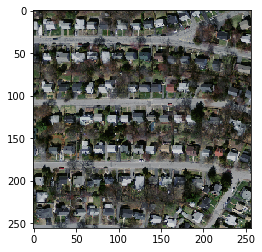

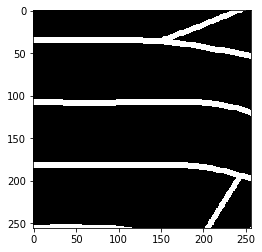

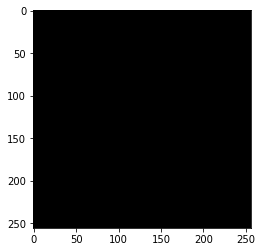

In [101]:
images_list = []
masks_list = []

for i, (b_images, b_labels) in enumerate(validation_generator):
        if (i * batch_size > 3):
            break
        else:
            for image, label in zip(b_images, b_labels):
                images_list.append(image)
                masks_list.append(label)

                n_images = len(images_list)

images_array = np.array(images_list)
masks_array = np.array(masks_list)

# Special images array reshape when using grayscale images
# if (c == 1):
#     plot_log.info("Ploting grayscale images (%d channel)" % c)
#     cmap = "gray"
#     images_array = np.reshape(a=images_array, newshape=(n_images, h, w, c))
#     masks_array = np.reshape(a=masks_array, newshape=(n_images, h, w, c))
# else:
print("Ploting color images (3 channel)")
cmap = None
images_array = np.reshape(a=images_array, newshape=(n_images, 256, 256, 3))
masks_array = np.reshape(a=masks_array, newshape=(n_images, 256, 256, 3))


predictions = model.predict(
        x=images_array, batch_size=batch_size, steps=None, verbose=0)

plt.imshow(images_array[0])
plt.show()
plt.imshow(masks_array[0])
plt.show()
plt.imshow(predictions[0])
plt.show()

## from sklearn.preprocessing import normalize
x = predictions[0,:,0,0]
norm1 = x / np.linalg.norm(x)
norm2 = normalize(x[:,np.newaxis], axis=0).ravel()
print (np.all(norm1 == norm2))
# True

In [61]:



prediction = np.reshape(scores[0], (256, 256, 3))
prediction_bgr = np.absolute(prediction)
print(prediction)
plt.imshow("Predicted Mask", prediction)
plt.show()

[[[ 1.  1.  1.]
  [ 1.  1.  1.]
  [ 1.  1.  1.]
  ..., 
  [ 1.  1.  1.]
  [ 1.  1.  1.]
  [ 1.  1.  1.]]

 [[ 1.  1.  1.]
  [ 1.  1.  1.]
  [ 1.  1.  1.]
  ..., 
  [ 1.  1.  1.]
  [ 1.  1.  1.]
  [ 1.  1.  1.]]

 [[ 1.  1.  1.]
  [ 1.  1.  1.]
  [ 1.  1.  1.]
  ..., 
  [ 1.  1.  1.]
  [ 1.  1.  1.]
  [ 1.  1.  1.]]

 ..., 
 [[ 1.  1.  1.]
  [ 1.  1.  1.]
  [ 1.  1.  1.]
  ..., 
  [ 1.  1.  1.]
  [ 1.  1.  1.]
  [ 1.  1.  1.]]

 [[ 1.  1.  1.]
  [ 1.  1.  1.]
  [ 1.  1.  1.]
  ..., 
  [ 1.  1.  1.]
  [ 1.  1.  1.]
  [ 1.  1.  1.]]

 [[ 1.  1.  1.]
  [ 1.  1.  1.]
  [ 1.  1.  1.]
  ..., 
  [ 1.  1.  1.]
  [ 1.  1.  1.]
  [ 1.  1.  1.]]]


TypeError: unhashable type: 'numpy.ndarray'

# Testing

In [1]:
model_name = 'VGG_16'
testPath = 'test/'

model = load_model('Models/' + model_name + 'model.h5')

test_datagen = ImageDataGenerator(
    rescale=1./255)

validation_generator = test_datagen.flow_from_directory(
        testPath,
        color_mode = 'rgb',
        class_mode = 'categorical',
        target_size=target_size,
        batch_size=batch_size,
        shuffle=False)  # keep data in same order as labels


# Final evaluation with test cases
scores = model.evaluate_generator(validation_generator) 
print('Scores: ', scores) 
print("Accuracy: %.2f%%" % (scores[1]*100)) 
print("Erro modelo: %.2f%%" % (100-scores[1]*100))

scores = model.predict_generator(validation_generator)
j, predicted_classes = np.unravel_index(scores.argmax(axis=1), scores.shape)

for i in range(0, scores.shape[0]):
    if predicted_classes[i] != validation_generator.classes[i]:#print failed images
        plt.imshow(imread(pathtest + validation_generator.filenames[i]))
        plt.show()
        print('true: ', validation_generator.classes[i])
        print('prediction: ',predicted_classes[i])
        print('scores: ', scores[i])
        print('file: ', validation_generator.filenames[i])
    

NameError: name 'ImageDataGenerator' is not defined

# Confusion Matrix + AUC

In [ ]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(validation_generator.classes, predicted_classes))

# AUC for prediction on validation sample
X_val_sample, val_labels = next(validation_generator)
val_pred = model.predict_proba(X_val_sample)
val_pred = np.reshape(val_pred, val_labels.shape)
val_score_auc = roc_auc_score(val_labels, val_pred)
print ("AUC validation score: ",val_score_auc)

# Data Augmentation

In [ ]:
dir_to_save = 'testes'
n_imgs = 10
#select image 
origin = '/media/marcelo/OS/Users/Marcelo Queirós/Documents/MIEI/Semestre 2/Tecnologias e Aplicacoes/deep learning/Projects/pills/dc/' 
image_path = origin + '1.jpg'

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=2,
    height_shift_range=2,
    horizontal_flip=True)

image = np.expand_dims(ndimage.imread(image_path),0) 


# fits the model on batches with real-time data augmentation:
#model.fit_generator(datagen.flow(x_train, y_train, batch_size=32),
                    #steps_per_epoch=len(x_train) / 32, epochs=epochs)
i = 0
for batch in datagen.flow(image, batch_size=1, 
                          save_to_dir = dir_to_save, save_prefix='dc', save_format='jpg'):
    i += 1
    if i > n_imgs:
        break  # otherwise the generator would loop indefinitely
        
#plots(aug_images, figsize=(20,7), rows=2)

In [111]:
import os
sys.path.append('C:\Program Files\Python35\Lib')
os.sys.path

['',
 'C:\\ProgramData\\Anaconda3\\python36.zip',
 'C:\\ProgramData\\Anaconda3\\DLLs',
 'C:\\ProgramData\\Anaconda3\\lib',
 'C:\\ProgramData\\Anaconda3',
 'C:\\Users\\mpinto\\AppData\\Roaming\\Python\\Python36\\site-packages',
 'C:\\ProgramData\\Anaconda3\\lib\\site-packages',
 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\Babel-2.5.0-py3.6.egg',
 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\win32',
 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\win32\\lib',
 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\Pythonwin',
 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\mpinto\\.ipython',
 '/usr/local/lib/python3.5/site-packages',
 '/usr/local/lib/python3.5/site-packages',
 '/usr/local/lib/python3.5/site-packages',
 'C:\\ProgramData\\Anaconda3\\Lib\\site-packages\\opencv_python-3.4.1.15.dist-info',
 '/usr/local/lib/python3.5/site-packages',
 'C:\\Program Files\\Python35\\Lib']

In [113]:
from __future__ import division, print_function, absolute_import

import os
import sys
import time
#import platform
import argparse
import cv2
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from PIL import Image
import signal
import keras
#from keras_tqdm import TQDMNotebookCallback
from keras.layers import Input
from keras.optimizers import Adam, RMSprop
from keras.models import Model, Sequential
from keras.models import load_model
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Conv2D, Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation
from keras.constraints import maxnorm 
from keras.optimizers import SGD 
from keras.utils import np_utils 
from keras import backend as K 
from keras.utils.data_utils import get_file
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
import keras
K.set_image_dim_ordering('tf') #ordem 'th' ou 'tf' 
import numpy as np
from numpy import genfromtxt
import math 

from timeit import default_timer as timer
from time import time as tick
import matplotlib.pyplot as plt 
import pickle 
from os import listdir
from PIL import Image, ImageOps
from os.path import isfile, join
import os
from scipy.misc	import toimage 
from scipy import misc, ndimage
import scipy.fftpack as pack
import scipy.misc
from scipy.ndimage import rotate
from sklearn.datasets import fetch_mldata
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from skimage.io import imread
from skimage.transform import resize

from sklearn.metrics import roc_auc_score
import pandas as pd
import pathlib

from keras.layers import (Activation, Conv2D, Conv2DTranspose, Dense, Dropout,
                          Flatten, Input, MaxPooling2D, concatenate,
                          GlobalAveragePooling2D)

# fixar random seed para se puder reproduzir os resultados 
seed = 1 
np.random.seed(seed)










# argument parser
custom_formatter_class = lambda prog: argparse.HelpFormatter(prog, max_help_position=2000)
parser = argparse.ArgumentParser(description="Road segmentation using Deep Learning.", 
                                 prefix_chars='-',
                                 formatter_class=custom_formatter_class) 
# optional arguments
parser.add_argument("--test_dir", required=False, help="Path to testing images", type=str)
parser.add_argument("--model_path", required=False, help="Path to trained model", type=str)
parser.add_argument("--width", required=False, help="Images width (default=256)", default=256, type=int)
parser.add_argument("--height", required=False, help="Images height (default=256)", default=256, type=int)
parser.add_argument("--save_path", required=False, help="Save output directory", type=str)
parser.add_argument("--delay", required=False, help="Delay between frames (default=0)", default=0, type=int)

# parse arguments
args = parser.parse_args()

# print commands line arguments
print(args, "\n")

# images properties
HEIGHT   = args.height
WIDTH    = args.width
CHANNELS = 3

# ////////////////////////////////////////////////
#                 Static paths
# ////////////////////////////////////////////////
if(args.test_dir is None): args.test_dir = "./images/"
if(args.model_path is None): args.model_path = "./model/unet_road_best_best.h5" 
# ////////////////////////////////////////////////


# ////////////////////////////////////////////////
#           Try to load test images
# ////////////////////////////////////////////////
try: 
    print("[INFO] Testing images folder:", args.test_dir)
    X, _ = image_dirs_to_samples(args.test_dir, resize=(WIDTH, HEIGHT), filetypes=[".png", ".jpg", ".bmp"])

    # images / ground truth split
    split = len(X) // 2
    Xim = X[:split]
    OXgt = X[split:] 

    # convert ground-truth images from GS to RGB
    OXgt = np.array(OXgt)
    OXgt = np.reshape(OXgt, (-1, HEIGHT, WIDTH, 1))
    Xgt = []

    for index, elem in enumerate(OXgt):
        Xgt.append(cv2.cvtColor(elem, cv2.COLOR_GRAY2RGB))
    
    Xgt = np.array(Xgt)
    Xgt = np.reshape(Xgt, (-1, HEIGHT, WIDTH, 3))
    
    print("[INFO] Images: ", len(Xim), Xim[0].shape)
    print("[INFO] Ground: ", len(Xgt), Xgt[0].shape)
    print("[INFO] Testing images loaded!\n", "green")

except Exception as load_data_exception:
    print("[EXCEPTION] %s" % load_data_exception, "red")
    sys.exit("[EXCEPTION] Error loading test images!")

# computational resources definition
tflearn.init_graph(num_cores=4)

# ////////////////////////////////////////////////
#       Network architecture definition
# ////////////////////////////////////////////////
network = input_data(shape=[None, HEIGHT, WIDTH, CHANNELS])





# ////////////////////////////////////////////////
#             Create model object 
# ////////////////////////////////////////////////    
model = tflearn.DNN(network)

try:
    print("")
    print("[INFO] Loading pre-trained model for testing...")  
    model.load(args.model_path)
    print("[INFO] Model:", args.model_path)
    print("[INFO] Trained model loaded!\n") 
except Exception as load_model_exception:
    print("[EXCEPTION] %s" % load_model_exception)
    sys.exit("[EXCEPTION] Error loading test images!")

# image index
n_images = len(Xim)
image_id = 0

# flag to upsample prediction image show
upsample = False

spacing = 50 
cv2.namedWindow("Original")
cv2.moveWindow("Original", spacing, spacing)
cv2.namedWindow("Ground Truth")
cv2.moveWindow("Ground Truth", spacing + WIDTH + 20, spacing)
cv2.namedWindow("Predicted Mask")
cv2.moveWindow("Predicted Mask", spacing, spacing + HEIGHT + spacing)
cv2.namedWindow("Predicted")
cv2.moveWindow("Predicted", spacing + WIDTH + 20, spacing + HEIGHT + spacing)

# while loop to constantly load images 
try:
    
    while image_id < n_images:
        # start measuring time
        ctime = time.time()

        try:
            frame = Xim[image_id]
        except Exception as load_frame_exception:
            print("[EXCEPTION] %s" % load_frame_exception)
            print("[EXCEPTION] Error loading frame!")
            continue

        # reshape test image to NHWC tensor format
        test_image = cv2.resize(frame, (WIDTH, HEIGHT), interpolation=cv2.INTER_CUBIC)
        copy_test_image = cv2.resize(frame, (WIDTH, HEIGHT), interpolation=cv2.INTER_CUBIC)
        test_image = np.reshape(test_image, (1, HEIGHT, WIDTH, CHANNELS)) 

        try:
            # output mask prediction
            prediction = model.predict(test_image)
            prediction = np.reshape(prediction[0], (HEIGHT, WIDTH, 3))
        except Exception as predict_exception:
            print("[EXCEPTION] %s" % predict_exception)
            print("[EXCEPTION] Error loading frame!")
            continue

        # original image 
        original_bgr = cv2.cvtColor(copy_test_image, cv2.COLOR_RGB2BGR)

        print("[INFO] Show original", original_bgr.shape)
        cv2.imshow("Original", original_bgr)

        # predicted segmentation 
        try:
            prediction_bgr = cv2.cvtColor(prediction, cv2.COLOR_RGB2BGR)
            prediction_bgr = np.absolute(prediction)
        except Exception as convert_pred_colorspace:
            print("[EXCEPTION] %s" % convert_pred_colorspace)
            print("[EXCEPTION] Prediction can't be converted to BGR colorspace!")
            prediction_bgr = prediction.copy()
            continue

        print("[INFO] Show predicted mask", prediction_bgr.shape)
        cv2.imshow("Predicted Mask", prediction)

        # ground truth
        try:
            gtruth = cv2.cvtColor(Xgt[image_id], cv2.COLOR_RGB2BGR)
        except Exception as convert_gt_colorspace:
            print("[EXCEPTION]  %s" % convert_gt_colorspace)
            print("[EXCEPTION] Ground truth can't be converted to BGR colorspace!")
            gtruth = Xgt[image_id]
        annotations = 0.5 * original_bgr + 0.5 * gtruth

        print("[INFO] Show ground truth", annotations.shape)
        cv2.imshow("Ground Truth", annotations)

        # prediction overlay 
        overlay = 0.5 * original_bgr + 0.5 * prediction_bgr
        if(upsample):
            overlay = cv2.resize(overlay, (WIDTH*2, HEIGHT*2), interpolation=cv2.INTER_CUBIC)

        print("[INFO] Show predicted", overlay.shape)
        cv2.imshow("Predicted", overlay)

        if(args.save_path is not None):
            cv2.imwrite("%soutput-%d.png" % (args.save_path, args.image_id), overlay)

        ctime = time.time() - ctime

        print("[INFO] Image %d of %d | Time %.3f seconds" % (image_id+1, n_images, ctime), end='\n\n')

        image_id += 1

        key = cv2.waitKey(args.delay)
        if(key == 27):
            # pressed ESC
            print("[INFO] Pressed ESC")
            break

except KeyboardInterrupt:
    print("[INFO] Pressed 'Ctrl+C'")

print("\n[INFO] All done!\a")


ModuleNotFoundError: No module named 'cv2'